# Exercise 1: Overview of the Acute pseudo-landmarking

**Author**: John Hodge

This is an introduction to the pseudo-landmarking method based around the `acute` function found within PlantCV. This tool is designed for morphometric analysis, which due to its relative simplicity, can easily scale between different datasets in order to capture informative shape data in the form of de novo landmarks.  This notebook serves as demonstration of the image data curration required by acute and also documents the initial outputs of `acute` which can be used either to optimize this workflow. Later exercises will build off of what is covered within this document in order to show the potential of this method to end users. To begin, let's start by loading the modules we'll need and then take stock of the acute function and how it operates by running help to see what inputs it requires...

Updated by Haley Schuhl to v4 (August 2023) 

In [1]:
%matplotlib inline
# Change inline to widget for interactive plots
from plantcv import plantcv as pcv
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
# PlantCV adjustable global parameters
pcv.params.debug = "plot"
pcv.params.text_size = 20
pcv.params.text_thickness = 10
pcv.params.line_thickness = 14
# Adjust plot sizes
pcv.params.dpi = 125

In [3]:
help(pcv.homology.acute)

Help on function acute in module plantcv.plantcv.homology.acute:

acute(img, mask, win, threshold)
    Identify landmark positions within a contour for morphometric analysis
    
    Inputs:
    img         = Original image used for plotting purposes
    mask        = binary mask used to generate contour array (necessary for ptvals)
    win         = maximum cumulative pixel distance window for calculating angle
                  score; 1 cm in pixels often works well
    threshold   = angle score threshold to be applied for mapping out landmark
                  coordinate clusters within each contour
    
    Outputs:
    homolog_pts = pseudo-landmarks selected from each landmark cluster
    start_pts   = pseudo-landmark island starting position; useful in parsing homolog_pts in downstream analyses
    stop_pts    = pseudo-landmark island end position ; useful in parsing homolog_pts in downstream analyses
    ptvals      = average values of pixel intensity from the mask used to gener

# Required image input variables

We'll need 4 variables for each image we run.  Two are derived from the image itself, a contour array representing the outline of a plants image mask (obj) and the image mask itself which is used for output purposes (mask). 

Let's first start by creating these first two objects. To begin, let's load our first image from a time series sequence.

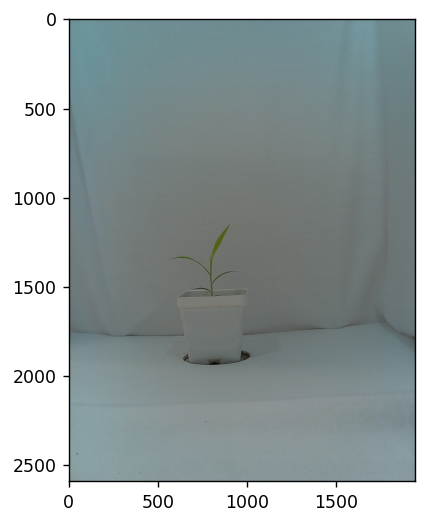

In [4]:
day = 10
path = "./imgs"
name = f"B100_rep1_d{day}"
# Read the image from a file
img, imgpath, imgname = pcv.readimage(filename=os.path.join(path, name + ".jpg"))

# Reviewing our loaded image

From what we can see, the plant is on a mostly homogeneous white background. It should be relatively easy to use the color channel differences to threshold the pixels representing our plant from the rest of the image to create our mask.  To begin let's take a look at the color channels to see which will be the most useful.

In comparing the 'Lab' and 'HSV' color spaces it appears there's a bit more contrast to work within the HSV space, but that soil near the stage for the pot could be a problem.  With that in mind the 'Lab' color space is our best bet. Let's take a look at which individual channels are the most informative...

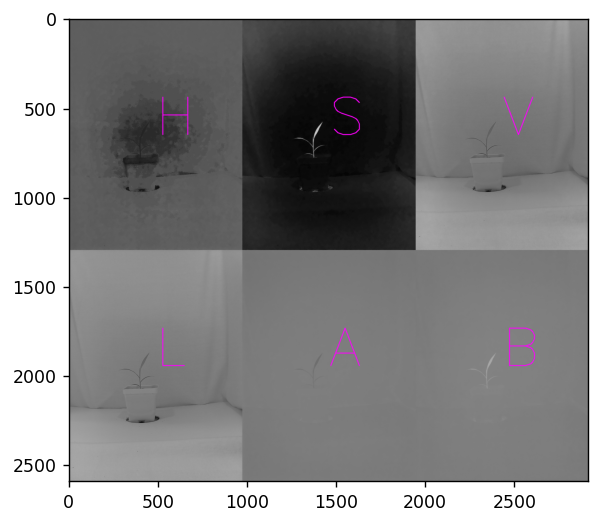

In [5]:
# Plot all Lab and HSV color channels
cs = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

# Binary thresholding

The 'L' channel unfortunately doesn't appear to help very much in denoting the plant pixels from the background.  However, there's good signal in the 'a' channel (darker pixels) and the 'b' channel (brighter pixels) so using a conjunction of these two grayscale images should give us a reasonable mask to work with!

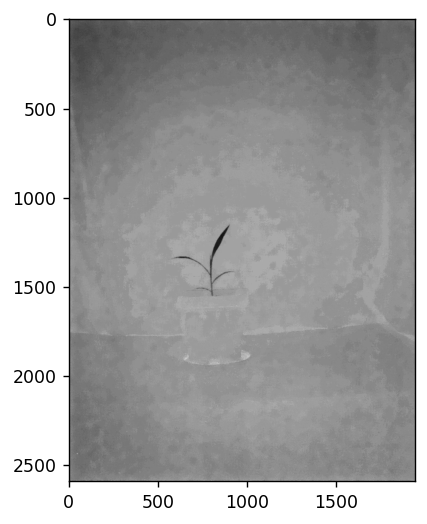

In [6]:
# Convert the RGB image to Lab and extract the "a" channel
img_a = pcv.rgb2gray_lab(rgb_img=img, channel="a")

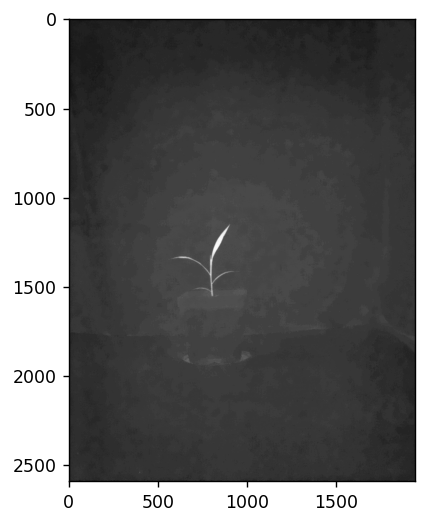

In [7]:
# Convert the RGB image to Lab and extract the "b" channel
img_b = pcv.rgb2gray_lab(rgb_img=img, channel="b")

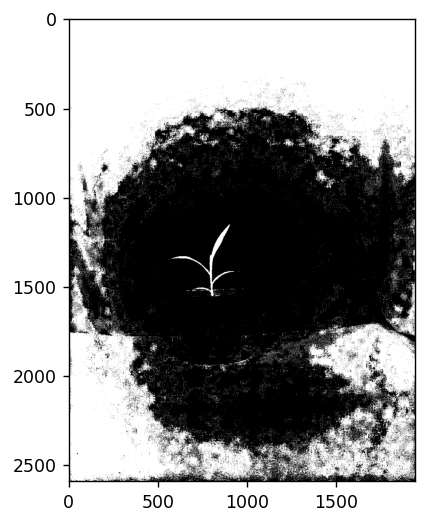

In [8]:
# Apply a binary threshold to the "a" channel grayscale image
mask_a = pcv.threshold.binary(gray_img=img_a, threshold=123, object_type="dark")

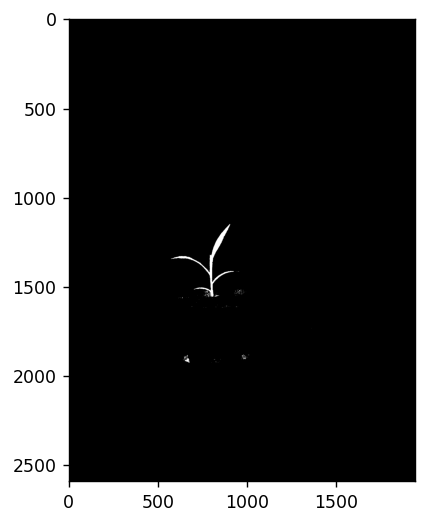

In [9]:
# Apply a binary threshold to the "b" channel grayscale image
mask_b = pcv.threshold.binary(gray_img=img_b, threshold=133, object_type="light")

# Merging binary thresholds into our mask

In both cases we have a few stray pixels (more so in mask a), but we're certainly on the right track! Now lets go ahead and identify which pixels these thresholds can agree on keeping.

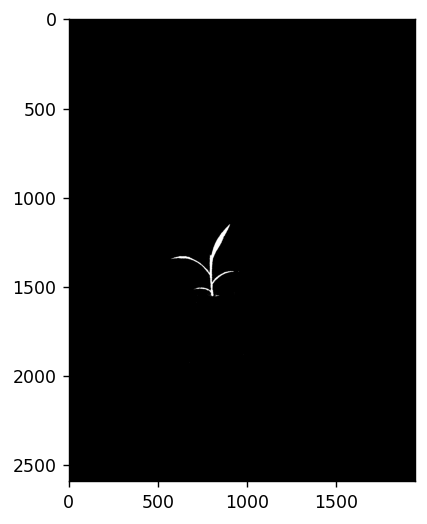

In [10]:
# Merge the two binary masks where the pixels are white in both a AND b
mask = pcv.logical_and(bin_img1=mask_a, bin_img2=mask_b)

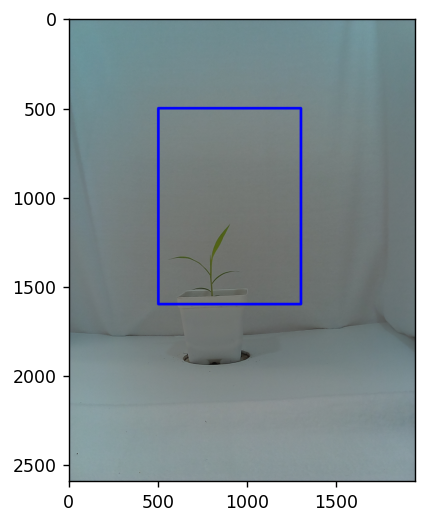

In [11]:
# Define a region of interest (ROI) that encompasses the plant area
roi = pcv.roi.rectangle(img=img, x=500, y=500, h=1100, w=800)

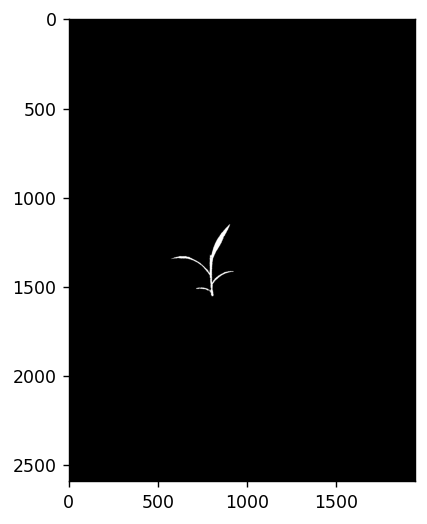

In [12]:
# Filter the objects using the ROI and return the largest object 
kept_mask  = pcv.roi.filter(mask=mask, roi=roi, roi_type='largest')


# Acute pseudo-landmark identification

Now that we have our contours we can come back to the previous two input parameters of `acute` which we have thus far ignored but are key to its functionality.  `acute` operates using a modified form of chain-coding akin to a navigators compass taking steps along a contour and within a local window two bounding points on either side of this window are defined from which an angle score can be calculated for the vertex of the 3 points.  The size of this local window is defined as a pixel distance using the `win` variable.  Following the calculation of this angle score it is then weighed against a threshold that is stored in our last variable `thresh` allowing for features of interest to be defined de novo.  Given that acute regions are often areas of interest for morphometric analysis setting this threshold to maximize the 'acuteness' of the contour serves to provide a relatively simple way to identify pseudo-landmarks. 

When specifying `win` it is often best to select a value which is at least half the distance of the smallest feature in the plant that is deemed relevant.  In the case of Setaria which we are using in this demonstration the first leaf is usually 2 cm long so selecting a window size <=1 cm is optimal to prevent conflict between adjacent landmarks along the contour.

When specifying `threshold` the best practice is to leave this value at 90 given in order to identify acute regions. However, to provide downstream flexibility this parameter has the capacity to use other user defined values in case more stringent or lax thresholds are required.


In [13]:
win = 24
thresh = 90

# Running acute in debugging mode

As is standard with other PlantCV modules, `acute` is built with debugging features that produces verbose outputs for the sake of troubleshooting. Given this is our first attempt at running this function lets go ahead and run it with debugging enabled to see what these outputs are... 

Note: while iterating through the contour list isn't necessary for a single outline as we have here this step is invaluable in later stages where volumes internal to our plant outline are present.


Landmark point indices: []
Starting site indices: []
Termination site indices: []
route C
Landmark site: 310, Start site: 287, Term. site: 333
Landmark point indices: [310]
Starting site indices: [287]
Termination site indices: [333]
route C
Landmark site: 555, Start site: 531, Term. site: 578
Landmark point indices: [310, 555]
Starting site indices: [287, 531]
Termination site indices: [333, 578]
route C
Landmark site: 885, Start site: 872, Term. site: 896
Landmark point indices: [310, 555, 885]
Starting site indices: [287, 531, 872]
Termination site indices: [333, 578, 896]
route C
Landmark site: 978, Start site: 951, Term. site: 1002
Landmark point indices: [310, 555, 885, 978]
Starting site indices: [287, 531, 872, 951]
Termination site indices: [333, 578, 896, 1002]
route C
Landmark site: 1112, Start site: 1083, Term. site: 1138
Landmark point indices: [310, 555, 885, 978, 1112]
Starting site indices: [287, 531, 872, 951, 1083]
Termination site indices: [333, 578, 896, 1002, 1138]

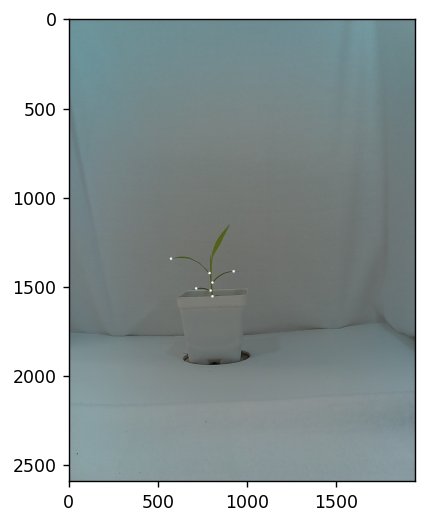

In [14]:
#objs = pcv._cv2_findcontours(bin_img=kept_mask)

homolog_pts, start_pts, stop_pts, ptvals, chain, max_dist = pcv.homology.acute(img=img, 
                                                                               mask=kept_mask, win=win, 
                                                                               threshold=thresh)
        

# Acute angle score chain-code output

We did quite a bit of work just above so let's go ahead and try to break it down item by item.  To start we successfully ran `acute` which used its chain coding based scoring method to identify landmarks (8 in this example).  However, we started with several hundred vertices comprising our outline (the purple dots we saw earlier) so how did we reduce those down to 8 pseudo-landmarks!? 

`acute` actually undergoes an extra step beyond simply calculating angle scores in that it attempts to identify 'islands' of acute points and upon finding these regions it approximates the best mid point of each location within the contour. Let's have a look at our contour described by it's acute angle scores...


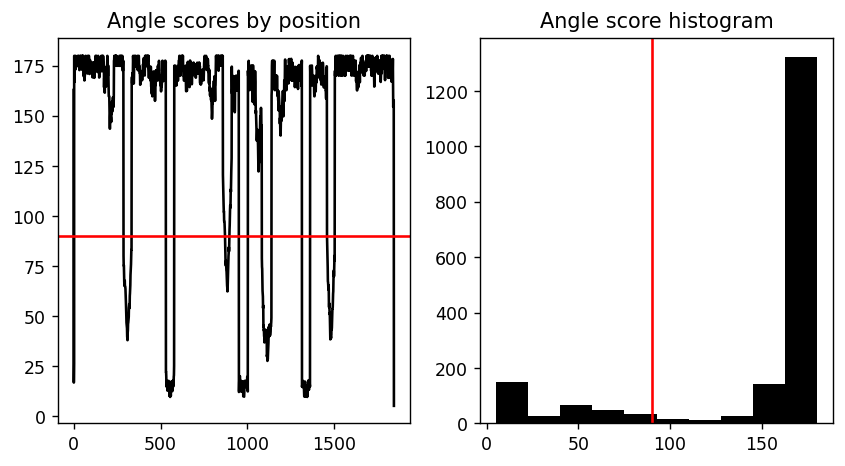

In [15]:
chain_pos=range(0, len(chain))

fig, (fig1, fig2) = plt.subplots(1, 2, figsize=(8, 4))

#Plot results
fig1.plot(chain_pos, chain, color='black')
fig1.axhline(y=thresh, color='r', linestyle='-')
fig1.set_title('Angle scores by position')

fig2.hist(chain, color='black')
fig2.axvline(x=thresh, color='r', linestyle='-')
fig2.set_title('Angle score histogram')

plt.show(fig)

If we focus on our first graph on the left the black line representing the individual acute angle scores of each vertex along our contour outline we can see there definitely seems to be a waveform that quickly decays to zero as we hit each acute island. It's also probably apparent we're actually splitting these islands in half at either end of our chain in linearizing this output.  The 'Fusing contour edges' step `acute` does automatically (appeared in the output panel) is performed to remedy mistaking these two segments as different regions. 

When we compare these regions to our threshold (the red line) it becomes clear these 'waves' correspond to our landmarks.  If we felt a particular need to optimize this threshold since we should optimally have a bimodal output a histogram of the angle scores can be generated as shown on the right to train this threshold in order to better optimize signal.

Now that we have a general idea of how `acute` is determining its primary outputs let's see how they compare to our original image...

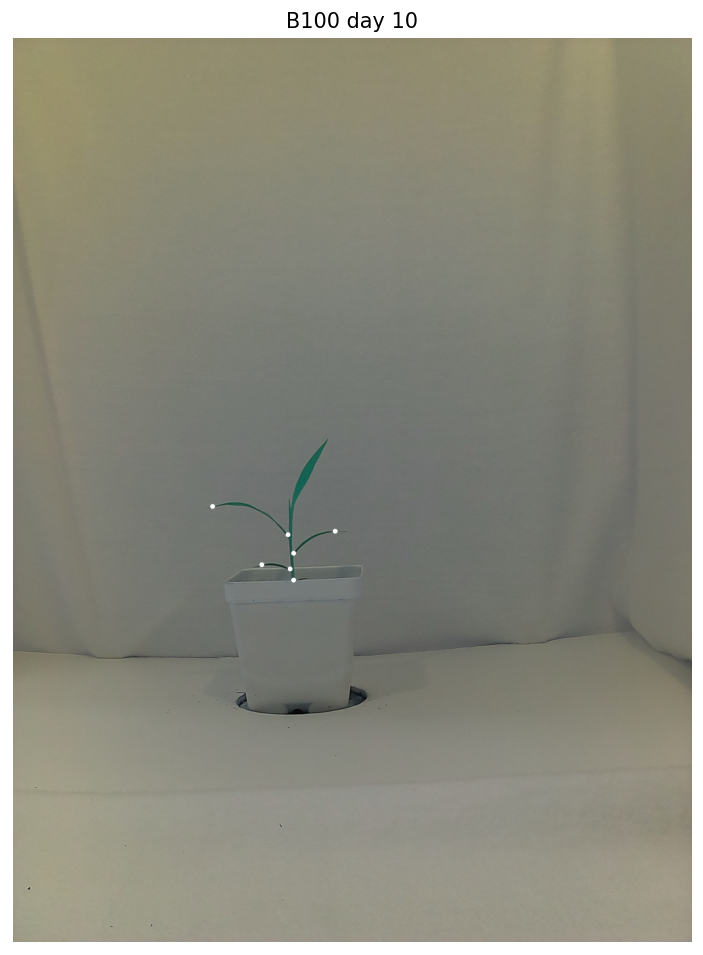

In [16]:
img_plms = img.copy()

cv2.drawContours(img_plms, homolog_pts, -1, (255, 255, 255), pcv.params.line_thickness)

#Plot results
plm_fig=plt.figure(figsize=(7, 10))
plm_fig=plt.imshow(img_plms)
plm_fig=plt.xscale('linear')
plm_fig=plt.axis('off')
plm_fig=plt.title('B100 day '+str(day))
plt.show(plm_fig)

In viewing our plms plotted in white while looking back on our original image we used for this exercise we can see that not only were we able to clearly define regions of interest using a threshold on our angle score waveforms but these do in fact appear to correlate with regions of interest for morphometric analysis such as the tips of leaves as well as the ligules where the base of each leaf attaches to the culm (the grass equivalent to a stem).  This is the basis by which `acute` functions and serves as the basic mode of operation for this workflow.  In the next exercise 2 we will expand on this knowledge by learning to interact with and store time series data which in exercise 3 can subsequently be fused together into homology groups.
